# Generate data for the smooth bathymetry runs

In [1]:
import os
from pathlib import Path
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import xgcm
import MITgcmutils.mds as mds
import cmocean.cm as cmo

In [2]:
base_path = Path('../../').resolve()

ensemble_path = base_path / 'data/raw/2d-models/ensemble_chain'
ensemble_path.mkdir(parents=True, exist_ok=True)

input_binary_files = ensemble_path / 'input_binary_files'
input_binary_files.mkdir(parents=True, exist_ok=True)

input_data_files = ensemble_path / 'input_data_files_a'
input_data_files.mkdir(parents=True, exist_ok=True)

## Original dataset manipulations
Here we open the original dataset, reformat it and then plot the mean density and velocity

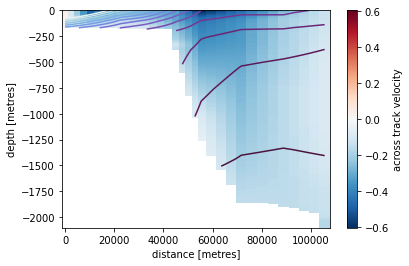

In [3]:
def open_observational_data():
    # Open the original dataset
    ds_orig = xr.open_dataset(base_path / 'data/raw/CFall_finergrid_2m.nc', chunks=-1)
    ds_orig = ds_orig.transpose('date', 'depth', 'distance', ...)
    ds_orig

    # Reformat the original dataset
    ds = ds_orig.copy(deep=True)

    ds['distance'] = (ds['distance'] - ds['distance'].isel(distance=0)) * 1e3
    ds['distance'].attrs = {'units': 'metres'}

    ds['depth'] = - ds['depth']
    ds['depth'].attrs = {'units': 'metres', 'convention': 'depth increases towards the surface'}

    return ds

ds_mean = open_observational_data().mean(dim='date').load()

fig, ax = plt.subplots()

cax0 = ds_mean['across track velocity'].plot(ax=ax)
cax1 = ds_mean['potential density'].plot.contour(ax=ax, levels=np.arange(26.5, 28, 0.1), cmap=cmo.dense)

## Create the model grid

In [4]:
# User defined grid parameters
H_min = -500
Lx = 150e3
Ly = 25

dz = 1
dx = 25
dy = 25

# Dataset creation
ny = int(Ly / dy)
nz = int(-H_min / dz)
nx = int(Lx / dx)

def create_grids():
    drF = -dz * np.ones(nz)

    xg = np.linspace(-0.5 * dx, Lx - 0.5 * dx, nx)  # Coordinate of left, u points
    xc = xg + dx * 0.5  # Coordinate of right v, eta, rho and h points

    xg_reversed = xg[::-1]
    xc_reversed = xc[::-1]
    
    yg = np.linspace(-0.5 * dy, Ly - 0.5 * dy, ny)  # Coordinate of left, u points
    yc = yg + dy * 0.5  # Coordinate of right v, eta, rho and h points

    zu = np.cumsum(drF)  # This is the lower coordinate of the vertical cell faces, i.e. the w points
    zl = np.concatenate(([0], zu[:-1]))  # This is the upper coordinate of the vertical cell faces
    z = 0.5 * (zl + zu)  # Vertical coordiante of the velocity points


    ds_grid = xr.Dataset(coords={'XG': xg,
                                 'XC': xc,
                                 'YG': yg,
                                 'YC': yc,
                                 'Zu': zu,
                                 'Zl': zl,
                                 'Z': z})
    grid = xgcm.Grid(ds_grid,
                     periodic=['X'],
                     coords={'X': {'left': 'XG', 'center': 'XC'},
                             'Z': {'left': 'Zu', 'right': 'Zl', 'center': 'Z'}})
    
    ds_reversed_xgrid = xr.Dataset(coords={'XG': xg_reversed,
                                           'XC': xc_reversed,
                                           'YG': yg,
                                           'YC': yc,
                                           'Zu': zu,
                                           'Zl': zl,
                                           'Z': z})
    
    reversed_xgrid = xgcm.Grid(ds_reversed_xgrid,
                     periodic=['X'],
                     coords={'X': {'left': 'XG', 'center': 'XC'},
                             'Z': {'left': 'Zu', 'right': 'Zl', 'center': 'Z'}})
    
    
    ds_reversed_zgrid = xr.Dataset(coords={'XG': xg,
                                           'XC': xc,
                                           'YG': yg,
                                           'YC': yc,
                                           'Zu': zu[::-1],
                                           'Zl': zl[::-1],
                                           'Z': z[::-1]})
    
    reversed_zgrid = xgcm.Grid(ds_reversed_zgrid,
                     periodic=['X'],
                     coords={'X': {'left': 'XG', 'center': 'XC'},
                             'Z': {'left': 'Zu', 'right': 'Zl', 'center': 'Z'}})
    
    ds_grid['deltaX'] = ('XC', dx * np.ones(nx))
    ds_grid['deltaY'] = ('YC', dy * np.ones(ny))
    ds_grid['deltaZ'] = ('Z', dz * np.ones(nz))
    
    return ds_grid, grid, reversed_xgrid, reversed_zgrid

ds_grid, grid, reversed_xgrid, reversed_zgrid = create_grids()
ds_input = ds_grid.copy(deep=True)

ds_grid

<xarray.Dataset>
Dimensions:  (XG: 6000, XC: 6000, YG: 1, YC: 1, Zu: 500, Zl: 500, Z: 500)
Coordinates:
  * XG       (XG) float64 -12.5 12.5 37.51 62.51 ... 1.499e+05 1.5e+05 1.5e+05
  * XC       (XC) float64 0.0 25.0 50.01 75.01 ... 1.499e+05 1.5e+05 1.5e+05
  * YG       (YG) float64 -12.5
  * YC       (YC) float64 0.0
  * Zu       (Zu) float64 -1.0 -2.0 -3.0 -4.0 ... -497.0 -498.0 -499.0 -500.0
  * Zl       (Zl) float64 0.0 -1.0 -2.0 -3.0 ... -496.0 -497.0 -498.0 -499.0
  * Z        (Z) float64 -0.5 -1.5 -2.5 -3.5 ... -496.5 -497.5 -498.5 -499.5
Data variables:
    deltaX   (XC) float64 25.0 25.0 25.0 25.0 25.0 ... 25.0 25.0 25.0 25.0 25.0
    deltaY   (YC) float64 25.0
    deltaZ   (Z) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0 1.0

## Create the idealised bathymetry
Now we want to fit an idealised curve to this data. We will try something of the form

$$h = h_0 (e^{- \lambda x} - 1) - h_1 \Bigg[\tanh\bigg(\frac{x - x_{mid}}{\delta}\bigg) + 1\Bigg]$$

Where all the fitted parameters are required to be positive and with

$$H_{min} = -2 h_1 - h_0$$

where $H_{min}$ must be chosen by hand.

Close to the coast the first term dominates giving an initial steep fall in depth. Further away the tanh term takes over.

We fit the data using the `scipy` function `curve_fit` which minimises the residuals between the observations and the fitted profile. We set an upper bound on the paramater $\lambda$ of $0.5 \times 10^{-3}$ m$^{-1}$ corresponding to a minimum bathymetric 'decay rate' of 2 km close to the surface, preventing the slope from being too steep.

In [5]:
def produce_depth():
    ds_depth = xr.Dataset(coords={'distance': ds_mean['distance'],
                                  'depth': ds_mean['depth']})

    # Extract the depth data from the 2D field
    ds_depth['2d_depth'] = ds_depth['distance'] * ds_depth['depth']
    ds_depth['2d_depth'] = ds_depth['2d_depth'] + (0 * ds_mean['potential density'])
    depth_args = ds_depth['2d_depth'].argmax('depth', skipna=False)
    ds_depth['h'] = ds_depth['depth'].isel(depth=depth_args)
    ds_depth['h'].values[0] = 0  # Set the depth at the first grid cell to zero
    return ds_depth

ds_depth = produce_depth()
ds_depth

<xarray.Dataset>
Dimensions:   (distance: 33, depth: 1052)
Coordinates:
  * distance  (distance) float64 0.0 2.5e+03 5e+03 ... 1.013e+05 1.055e+05
  * depth     (depth) float64 -0.0 -2.0 -4.0 ... -2.098e+03 -2.1e+03 -2.102e+03
Data variables:
    2d_depth  (distance, depth) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    h         (distance) float64 0.0 -170.0 -170.0 ... -1.964e+03 -1.988e+03

h_0 = 179.30, lambda = 5.00e-04, x_mid = 45069.31, delta = 305.08


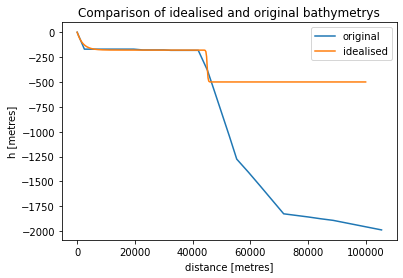

In [6]:
from scipy.optimize import curve_fit

def depth_function(x, h0, lambdaa, xm, delta):
    h1 = - 0.5 * (H_min + h0)
    h_upper = h0 * (np.exp(-x * lambdaa) - 1)
    h_lower =  - h1 * (np.tanh((x - xm) / delta) + 1)
    return h_upper + h_lower

params, _ = curve_fit(depth_function, ds_depth['distance'], ds_depth['h'],
                      bounds=(0, (np.inf, 1/2e3, np.inf, np.inf)),
                      p0=(250, 1/10e3, 40e3, 30e3))

def plot_the_idealised_bathmetry():
    # Evaluate the idealised depth function
    X = np.linspace(0, 100e3, 400)
    idealised_depth = depth_function(X, *params)

    # Plot the observed depth and idealised depth together.
    fig, ax = plt.subplots()
    ds_depth['h'].plot(label='original', ax=ax)
    ax.plot(X, idealised_depth, label='idealised')
    ax.legend()
    ax.set_title("Comparison of idealised and original bathymetrys")

    print('h_0 = {:.2f}, lambda = {:.2e}, x_mid = {:.2f}, delta = {:.2f}'.format(*params))
    return fig

plot_the_idealised_bathmetry()
plt.show()

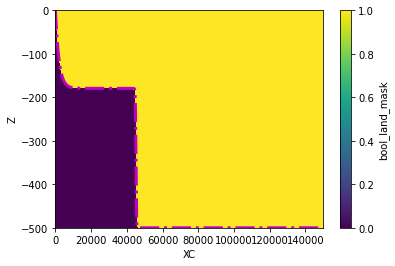

In [7]:
# Make and plot the bathymetry masks
ds_input['bathymetry'] = xr.DataArray(depth_function(ds_input['XC'], *params))
ds_input['bathymetry'].plot(lw=3, c='m', ls='-.')

ds_input['bool_land_mask'] = xr.where(ds_input['bathymetry'] <= ds_input['Z'], 1, 0)
ds_input['nan_land_mask'] = xr.where(ds_input['bathymetry'] <= ds_input['Z'], 1, np.nan)

ds_input['bool_land_mask'].plot()

plt.show()

## Interpolate to the smooth grid

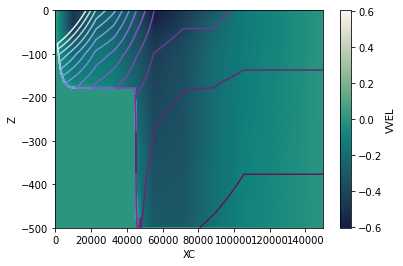

In [8]:
def calculate_bottom_indices():
    # Land masked depth
    depth_land_masked = ds_input['bool_land_mask'] * ds_input['Z']
    bottom_depth_indices = depth_land_masked.argmin('Z')    
    return bottom_depth_indices

bottom_depth_indices = calculate_bottom_indices()

east_boundary_vvel = xr.zeros_like(ds_input['Z'])
bottom_boundary_vvel = xr.zeros_like(ds_input['XC'])

east_boundary_density = ds_mean['potential density'].isel(distance=-1).interp({'depth': ds_input['Z']})
bottom_boundary_density = 'density'

def put_da_on_ideal_grid(da, east_boundary_values, bottom_boundary_values):
    if type(bottom_boundary_values) == str:
        if bottom_boundary_values == 'density':
            density = True
        else:
            raise ValueError("`bottom_boundary_values` must be 'density' or array like")
    else:
        density = False
    
    da_model_grid = da.interp({'distance': ds_input['XC'], 'depth': ds_input['Z']})
    
    # Set the array values at the bottom and eastern boundaries
    if density:
        da_model_grid[bottom_depth_indices] = xr.full_like(ds_input['XC'], np.nan)
    else:
        da_model_grid[bottom_depth_indices] = bottom_boundary_values

    da_model_grid[:, -1] = east_boundary_values
    
    if density:
        da_filled = da_model_grid[::-1].interpolate_na(dim='Z', method='linear', fill_value='extrapolate')[::-1]
        da_filled = da_filled.interpolate_na(dim='XC', method='linear')

    else:
        da_filled = da_model_grid[::-1].interpolate_na(dim='Z', method='linear')[::-1]
        da_filled = da_filled.interpolate_na(dim='XC', method='linear')
    
    # Remove the extra grid points
    da_on_ideal_grid = ds_input['nan_land_mask'] * da_filled
    da_on_ideal_grid = da_on_ideal_grid.fillna(0)
    return da_on_ideal_grid

ds_input['VVEL'] = put_da_on_ideal_grid(ds_mean['across track velocity'], east_boundary_vvel, bottom_boundary_vvel)
ds_input['sigma'] = put_da_on_ideal_grid(ds_mean['potential density'], east_boundary_density, bottom_boundary_density)

fig, ax = plt.subplots()
ds_input['VVEL'].plot(ax=ax, cmap=cmo.tempo_r)
ds_input['sigma'].plot.contour(levels=np.arange(26.5, 28, 0.1), ax=ax, cmap=cmo.dense)
plt.show()

## An idealised approach

The density profile created by interpolation is not smooth and is unstable in places. The velocity profile is also a little strange. To get around this we can prescribe an idealised velocity profile and by putting it in thermal 
balance extract a density profile

### The velocity

We will chose a velocity profile that is given by

$$V = V_L(x, z) + V_r(x, z)$$

where 

$$V_i = V_0 \exp\bigg[ - \frac{(x - x_m) ^ 2}{2 \sigma_{x}^2} \bigg] \bigg(\frac{Z - Z_m}{\sigma_z} + 1\bigg)$$

We fit the parameters by eye to create jets similar to those in the observations

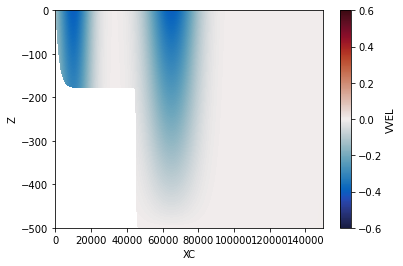

In [9]:
def input_velocity(X, Z, mask=None):
    V0L = -0.2
    V0L = -0.4
    xmL = 10e3
    sigmaxL = 7e3
    zmL = - 0
    sigmazL = 750
    
    V0R = -0.6
    V0R = -0.4
    xmR = 65e3
    sigmaxR = 10e3
    zmR = - 0
    sigmazR = - H_min

    VL = gaussian_jet(X, Z, V0L, xmL, sigmaxL, zmL, sigmazL)
    VR = gaussian_jet(X, Z, V0R, xmR, sigmaxR, zmR, sigmazR)
    
    V = VL + VR
    if mask is not None:
        V = V * ds_input['nan_land_mask']
    return V


def gaussian_jet(X, Z, V0, Xmid, sigmaX, Zmid, sigmaZ):
    #. VZ = np.exp((Z - Zmid) / 2 / sigmaZ)
    VZ = (Z - Zmid) / sigmaZ + 1
    VX = np.exp(-np.square(X - Xmid) / 2 / np.square(sigmaX))
    V = V0 * VZ * VX
    return V

ds_input['VVEL'] = input_velocity(ds_input['XC'], ds_input['Z'], mask=ds_input['nan_land_mask'])
ds_input['VVEL'].plot(cmap=cmo.balance, vmin=-0.6, vmax=0.6)
ds_input['UVEL'] = xr.zeros_like(ds_input['Z'] * ds_input['XG'])

### The density

We get the density profile by using thermal 
balance. When we integrate we do so from the eastern boundary to avoid weird western boundary effects.

#### Reference density profile

In [10]:
H_min

-500

In [11]:
-500 + 1e-7 < H_min - dz

False

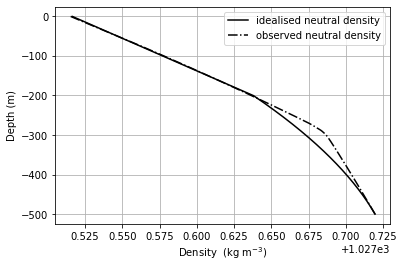

rho_0 = 1027.5163897376408
k1 = <xarray.DataArray 'polyfit_coefficients' ()>
array(-0.00060862)
Coordinates:
    degree   int64 1
c1 = <xarray.DataArray 'polyfit_coefficients' ()>
array(1027.51608543)
Coordinates:
    degree   int64 0
k2 = <xarray.DataArray 'polyfit_coefficients' ()>
array(-0.00015471)
Coordinates:
    degree   int64 1
c2 = <xarray.DataArray 'polyfit_coefficients' ()>
array(1027.6422616)
Coordinates:
    degree   int64 0
a = -3.985795350675503e-07
b = -0.0005516979835916993
c = 1027.5434122780807


In [12]:
from scipy.interpolate import interp1d
from scipy.stats import linregress
from scipy.linalg import solve

def create_idealised_reference_density(observed_reference_density):
    # Set the depths at which to switch profiles
    z_therm = -200 + 1e-7 # Depth at which the linear surface profile ends
    z_bound = -500 + 2 # Depth at which the linear deep profile starts

    surf_rho = observed_reference_density.sel(Z=slice(0, z_therm))
    mid_rho = observed_reference_density.sel(Z=slice(z_therm, z_bound))
    deep_rho = observed_reference_density.sel(Z=slice(z_bound, H_min))

    # Use observations to linearly fit the deep profile
    k2, c2 = deep_rho.polyfit('Z', 1)['polyfit_coefficients']
    interp_deep_rho = k2 * deep_rho['Z'] + c2

    # Use observations to linearly fit the surface profile
    k1, c1 = surf_rho.polyfit('Z', 1)['polyfit_coefficients']
    interp_surf_rho = k1 * surf_rho['Z'] + c1

    # Fit a second order polynomial to the middle density profile
    # Match the density and its derivative at the boundary layer
    # Match the the density, but not its derivative at the the thermocline
    rho_therm = k1 * z_therm + c1
    rho_bound = k2 * z_bound + c2
    A = np.array([[z_therm ** 2 , z_therm, 1],[z_bound ** 2, z_bound, 1],[2 * z_bound, 1, 0]])
    bprime = np.array([rho_therm, rho_bound, k2])
    a, b, c = solve(A, bprime)  # rho = a * z ** 2 + b * z + c
    interp_mid_rho = a * mid_rho['Z'] * mid_rho['Z']  + b * mid_rho['Z'] + c
    
    ds_input['rho_ref'] = xr.concat([interp_surf_rho, interp_mid_rho, interp_deep_rho], dim='Z')

    rho_0 = ds_input['rho_ref'][0].values

    plt.plot(ds_input['rho_ref'], ds_input['Z'], c='k', ls='-', label='idealised neutral density')
    plt.plot(observed_reference_density, observed_reference_density['Z'], c='k', ls='-.', label='observed neutral density')


    plt.xlabel('Density  (kg m$^{-3}$)')
    plt.ylabel('Depth (m)')
    plt.grid()
    plt.legend()
    plt.show()

    print('rho_0 =', rho_0)
    print('k1 =', k1)
    print('c1 =', c1)
    print('k2 =', k2)
    print('c2 =', c2)
    print('a =', a)
    print('b =', b)
    print('c =', c) 
    
create_idealised_reference_density(ds_input['sigma'].isel(XC=-1) + 1000)

Here we create the idealised density profile from the target velocity profile. Later we convert this back into a velocity profile. In the below we multiply the theoretical drho_dx by 0.9 to lessen the isopycnal slope and increase the PV.

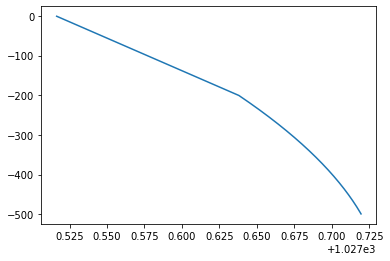

In [13]:
plt.plot(ds_input['rho_ref'], ds_input['Z'])
plt.show()

stratification is stable


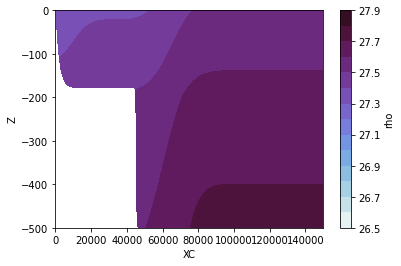

In [14]:
rho_0 = 1000
g = 9.81
f = 1.26e-4

def create_idealized_density(ds_input, rho_ref):
    V = input_velocity(ds_input['XG'], ds_input['Zl'])
    dv_dz = grid.diff(V, 'Z', boundary='extrapolate')
    drho_dx = - f * rho_0 / g * dv_dz

    rho = rho_ref + reversed_xgrid.cumsum(drho_dx[:, ::-1], 'X') * dx * 0.5
    rho = rho * ds_input['nan_land_mask']
    return rho

ds_input['rho'] = create_idealized_density(ds_input, ds_input['rho_ref'])
(ds_input['rho'] - 1000).plot(cmap=cmo.dense, levels=np.arange(26.5, 28, 0.1))

if xr.where(ds_input['rho'].diff('Z') < 0, 1, 0).sum() != 0:
    print('stratification is unstable')
    print(xr.where(ds_input['rho'].diff('Z') < 0, 1, 0).sum().values)
else:
    print('stratification is stable')

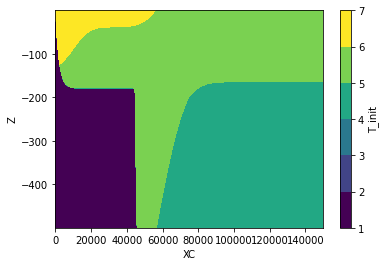

In [15]:
# Convert density into temperature
import okapy.thermo as okt

T_0, rho_0, alpha = 8, 1027, 2e-4

ds_input['rho_ref'] = ds_input['rho'].isel(XC=-1).fillna(0)

ds_input['T_ref'] = okt.T_from_rho(ds_input['rho_ref'], rho_0, alpha) + T_0
ds_input['T_init'] = (okt.T_from_rho(ds_input['rho'], rho_0, alpha) + T_0)
ds_input['T_init'] = ds_input['T_init'].fillna(1)

ds_input['T_init'].plot.contourf()

ds_input['S_ref'] = xr.zeros_like(ds_input['Z'])
ds_input['S_init'] = ds_input['S_ref'].broadcast_like(ds_input['XC'])

### Convert the density back to a velocity

In [16]:
ds_input['rho']

<xarray.DataArray 'rho' (Z: 500, XC: 6000)>
array([[          nan, 1027.3321431 , 1027.33217404, ..., 1027.51638974,
        1027.51638974, 1027.51638974],
       [          nan, 1027.33275171, 1027.33278266, ..., 1027.51699835,
        1027.51699835, 1027.51699835],
       [          nan,           nan, 1027.33339127, ..., 1027.51760697,
        1027.51760697, 1027.51760697],
       ...,
       [          nan,           nan,           nan, ..., 1027.7192311 ,
        1027.7192311 , 1027.7192311 ],
       [          nan,           nan,           nan, ..., 1027.71938591,
        1027.71938591, 1027.71938591],
       [          nan,           nan,           nan, ..., 1027.71954062,
        1027.71954062, 1027.71954062]])
Coordinates:
  * XC        (XC) float64 0.0 25.0 50.01 75.01 ... 1.499e+05 1.5e+05 1.5e+05
  * Z         (Z) float64 -0.5 -1.5 -2.5 -3.5 ... -496.5 -497.5 -498.5 -499.5
    distance  (XC) float64 0.0 25.0 50.01 75.01 ... 1.499e+05 1.5e+05 1.5e+05
    depth     (Z) float64 -0.5 -1.5 -2.5 -3.5 ... -496.5 -497.5 -498.5 -499.5

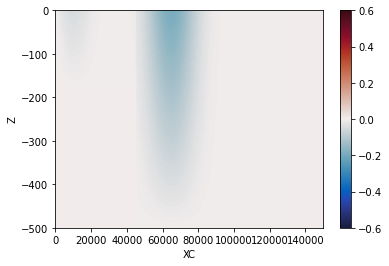

In [17]:
db_dx = g / rho_0 * grid.diff(ds_input['rho'], 'X') / dx
db_dx_interp = grid.interp(db_dx, ['X', 'Z'], boundary='fill')

V = reversed_zgrid.cumsum(db_dx_interp[::-1], 'Z') * -dz / f
clim=0.6
V.plot(cmap=cmo.balance, vmin=-clim, vmax=clim)

try:
    ds_input['VVEL_orig']
except:
    ds_input['VVEL_orig'] = ds_input['VVEL']

ds_input['VVEL'] = V

V.min()
plt.show()

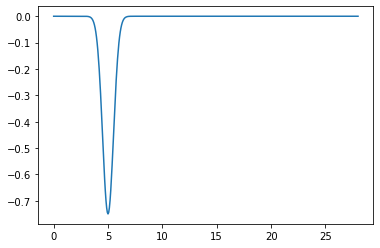

niters = 40320.0
forcing_period = 5400.0 seconds


In [18]:
hours = 60 * 60
days = 24 * hours

deltat = 60
end_time = 28 * days
niters = end_time / deltat

forcing_period = 1.5 * hours
exf_forcing_iters = forcing_period / deltat

tmid = 5 * days
sigmat = 0.5 * days
tau_max = - 0.75

times = xr.DataArray(np.arange(0, end_time + 1e-9, forcing_period), name='time', dims='time')
nt = len(times)

def wind_stress(t, tmid=tmid, sigmat=sigmat):
    stress = tau_max * np.exp(-np.square((t - tmid)) / 2 / np.square(sigmat)) * xr.ones_like(ds_input['XC'])
    return stress

ds_input['merid_wind_stress'] = wind_stress(times)

plt.plot(times / 24 / 60 / 60, ds_input['merid_wind_stress'].isel(XC=0))
plt.show()

print('niters = {}'.format(niters))
print('forcing_period = {} seconds'.format(forcing_period))


## Check the PV

No SI


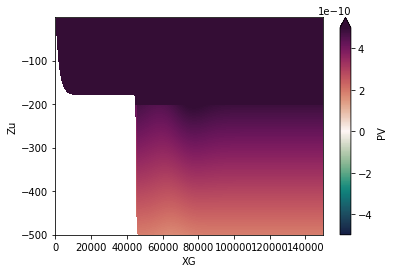

In [19]:
def calculate_2d_pv(ds, grid, f=1.26e-4):

    drC_vel = -dz

    zeta_x =  - grid.diff(ds['VVEL'], 'Z', boundary='extend') / drC_vel
    zeta_z = grid.diff(ds['VVEL'], 'X') / dx

    fx = 0

    g = 9.81
    ds['sigma'] = ds['rho'] - 1000
    ds['b'] = - g * ds['sigma'] / 1000

    bx = grid.interp(ds['b'], ['Z'], boundary='extend')
    bz = grid.interp(ds['b'], ['X'])

    PVx = grid.diff(bx * (zeta_x + fx), 'X') / dx
    PVz = grid.diff(bz * (zeta_z + f), 'Z', boundary='extend') / drC_vel

    ds['PV'] = PVx + PVz
    ds['zeta_x'] = zeta_x
    
    return ds

da_pv = calculate_2d_pv(ds_input, grid)['PV']

da_pv.plot(vmin=-5e-10, vmax=5e-10, cmap=cmo.curl)
print('No SI') if da_pv.min() >= 0 else print('Yes SI')

plt.show()

## File check list
- UVEL init
- VVEL init
- Bathymetry (Y, X)
- dz
- T init
- T ref
- S init
- S ref
- meridional wind stress


In [20]:
variable_list = ['VVEL',
                 'UVEL',
                 'bathymetry',
                 'T_init',
                 'T_ref',
                 'S_init',
                 'S_ref',
                 'merid_wind_stress'
                ]
for var in variable_list:
    print(var)
    ds_input[var] = ds_input[var].fillna(0)
ds_input

VVEL
UVEL
bathymetry
T_init
T_ref
S_init
S_ref
merid_wind_stress


<xarray.Dataset>
Dimensions:            (Z: 500, XC: 6000, XG: 6000, YG: 1, YC: 1, Zu: 500,
                        Zl: 500, time: 449)
Coordinates:
  * Z                  (Z) float64 -0.5 -1.5 -2.5 -3.5 ... -497.5 -498.5 -499.5
  * XC                 (XC) float64 0.0 25.0 50.01 ... 1.499e+05 1.5e+05 1.5e+05
  * XG                 (XG) float64 -12.5 12.5 37.51 ... 1.5e+05 1.5e+05
  * YG                 (YG) float64 -12.5
  * YC                 (YC) float64 0.0
  * Zu                 (Zu) float64 -1.0 -2.0 -3.0 -4.0 ... -498.0 -499.0 -500.0
  * Zl                 (Zl) float64 0.0 -1.0 -2.0 -3.0 ... -497.0 -498.0 -499.0
    distance           (XC) float64 0.0 25.0 50.01 ... 1.499e+05 1.5e+05 1.5e+05
    depth              (Z) float64 -0.5 -1.5 -2.5 -3.5 ... -497.5 -498.5 -499.5
Dimensions without coordinates: time
Data variables: (12/20)
    deltaX             (XC) float64 25.0 25.0 25.0 25.0 ... 25.0 25.0 25.0 25.0
    deltaY             (YC) float64 25.0
    deltaZ             (Z) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    bathymetry         (XC) float64 0.0 -2.228 -4.428 ... -500.0 -500.0 -500.0
    bool_land_mask     (Z, XC) int64 0 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    nan_land_mask      (Z, XC) float64 nan 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    ...                 ...
    S_init             (XC, Z) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    VVEL_orig          (Z, XC) float64 nan -0.1448 ... -8.364e-20 -8.188e-20
    merid_wind_stress  (time, XC) float64 -1.447e-22 -1.447e-22 ... -0.0 -0.0
    b                  (Z, XC) float64 nan -0.2681 -0.2681 ... -0.2719 -0.2719
    PV                 (Zu, XG) float64 nan nan 0.0 ... 1.912e-10 1.912e-10
    zeta_x             (Zu, XC) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [21]:
def broadcast_to_3d_vars(ds_input):
    ds_3d = xr.Dataset()
    
    ds_3d['VVEL'] = ds_input['VVEL'].broadcast_like(ds_input['YG'])
    ds_3d['UVEL'] = ds_input['UVEL'].broadcast_like(ds_input['YC'])
    ds_3d['VVEL_bound'] = ds_input['VVEL']
    
    ds_3d['bathymetry'] = ds_input['bathymetry'].broadcast_like(ds_input['YC'])
    
    ds_3d['deltaX'] = ds_input['deltaX']
    ds_3d['deltaY'] = ds_input['deltaY']
    ds_3d['deltaZ'] = ds_input['deltaZ']

    ds_3d['T_bound'] = ds_input['T_init']
    ds_3d['T_init'] = ds_input['T_init'].broadcast_like(ds_input['YC'])
    ds_3d['T_ref'] = ds_input['T_ref']
 
    ds_3d['S_init'] = ds_input['S_init'].broadcast_like(ds_input['YC'])
    ds_3d['S_ref'] = ds_input['S_ref']
    
    ds_3d['merid_wind_stress'] = ds_input['merid_wind_stress']
    ds_3d = ds_3d.transpose('time', 'Z', 'Zl', 'Zu', 'Zp1', 'YG', 'YC', 'XG', 'XC', missing_dims='ignore')
    return ds_3d

ds_3d = broadcast_to_3d_vars(ds_input)
ds_3d

<xarray.Dataset>
Dimensions:            (Z: 500, XC: 6000, YG: 1, XG: 6000, YC: 1, time: 449)
Coordinates:
  * Z                  (Z) float64 -0.5 -1.5 -2.5 -3.5 ... -497.5 -498.5 -499.5
  * XC                 (XC) float64 0.0 25.0 50.01 ... 1.499e+05 1.5e+05 1.5e+05
    distance           (XC) float64 0.0 25.0 50.01 ... 1.499e+05 1.5e+05 1.5e+05
    depth              (Z) float64 -0.5 -1.5 -2.5 -3.5 ... -497.5 -498.5 -499.5
  * YG                 (YG) float64 -12.5
  * XG                 (XG) float64 -12.5 12.5 37.51 ... 1.5e+05 1.5e+05
  * YC                 (YC) float64 0.0
Dimensions without coordinates: time
Data variables: (12/13)
    VVEL               (Z, YG, XC) float64 -0.0 -0.0 -0.0001411 ... -0.0 -0.0
    UVEL               (Z, YC, XG) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    VVEL_bound         (Z, XC) float64 -0.0 -0.0 -0.0001411 ... -0.0 -0.0 -0.0
    bathymetry         (YC, XC) float64 0.0 -2.228 -4.428 ... -500.0 -500.0
    deltaX             (XC) float64 25.0 25.0 25.0 25.0 ... 25.0 25.0 25.0 25.0
    deltaY             (YC) float64 25.0
    ...                 ...
    T_bound            (Z, XC) float64 1.0 6.383 6.383 ... 4.497 4.497 4.497
    T_init             (Z, YC, XC) float64 1.0 6.383 6.383 ... 4.497 4.497 4.497
    T_ref              (Z) float64 5.486 5.483 5.48 5.477 ... 4.498 4.498 4.497
    S_init             (Z, YC, XC) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    S_ref              (Z) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    merid_wind_stress  (time, XC) float64 -1.447e-22 -1.447e-22 ... -0.0 -0.0

# Generation of ensemble members data

In [22]:
variable_list = ['VVEL',
                 'UVEL',
                 'VVEL_bound',
                 'bathymetry',
                 'deltaX',
                 'deltaY',
                 'deltaZ',
                 'T_init',
                 'T_ref',
                 'T_bound',
                 'S_init',
                 'S_ref',]
                 #'merid_wind_stress']


for var in variable_list:
    fbase = str(input_binary_files / var)
    #mds.wrmds(fbase, ds_3d[var].values, dataprec='float32')

In [23]:
from itertools import product
import numpy as np
days = 24 * 60 * 60

In [24]:
tau_max_arr = np.linspace(0, -0.75, 10)
sigmat_arr = np.linspace(1e-9, 5 * days, 5)

wind_params = list(product(tau_max_arr, sigmat_arr))
len(wind_params)

50

In [25]:
wind_params

[(0.0, 1e-09),
 (0.0, 108000.00000000076),
 (0.0, 216000.0000000005),
 (0.0, 324000.00000000023),
 (0.0, 432000.0),
 (-0.08333333333333333, 1e-09),
 (-0.08333333333333333, 108000.00000000076),
 (-0.08333333333333333, 216000.0000000005),
 (-0.08333333333333333, 324000.00000000023),
 (-0.08333333333333333, 432000.0),
 (-0.16666666666666666, 1e-09),
 (-0.16666666666666666, 108000.00000000076),
 (-0.16666666666666666, 216000.0000000005),
 (-0.16666666666666666, 324000.00000000023),
 (-0.16666666666666666, 432000.0),
 (-0.25, 1e-09),
 (-0.25, 108000.00000000076),
 (-0.25, 216000.0000000005),
 (-0.25, 324000.00000000023),
 (-0.25, 432000.0),
 (-0.3333333333333333, 1e-09),
 (-0.3333333333333333, 108000.00000000076),
 (-0.3333333333333333, 216000.0000000005),
 (-0.3333333333333333, 324000.00000000023),
 (-0.3333333333333333, 432000.0),
 (-0.41666666666666663, 1e-09),
 (-0.41666666666666663, 108000.00000000076),
 (-0.41666666666666663, 216000.0000000005),
 (-0.41666666666666663, 324000.00000000

/mnt/lustre/a2fs-work1/work/n01/n01/fwg/irminger-proj/data/raw/2d-models/ensemble_chain/run0_a
/mnt/lustre/a2fs-work1/work/n01/n01/fwg/irminger-proj/data/raw/2d-models/ensemble_chain/run1_a
/mnt/lustre/a2fs-work1/work/n01/n01/fwg/irminger-proj/data/raw/2d-models/ensemble_chain/run2_a
/mnt/lustre/a2fs-work1/work/n01/n01/fwg/irminger-proj/data/raw/2d-models/ensemble_chain/run3_a
/mnt/lustre/a2fs-work1/work/n01/n01/fwg/irminger-proj/data/raw/2d-models/ensemble_chain/run4_a
/mnt/lustre/a2fs-work1/work/n01/n01/fwg/irminger-proj/data/raw/2d-models/ensemble_chain/run5_a
/mnt/lustre/a2fs-work1/work/n01/n01/fwg/irminger-proj/data/raw/2d-models/ensemble_chain/run6_a
/mnt/lustre/a2fs-work1/work/n01/n01/fwg/irminger-proj/data/raw/2d-models/ensemble_chain/run7_a
/mnt/lustre/a2fs-work1/work/n01/n01/fwg/irminger-proj/data/raw/2d-models/ensemble_chain/run8_a
/mnt/lustre/a2fs-work1/work/n01/n01/fwg/irminger-proj/data/raw/2d-models/ensemble_chain/run9_a
/mnt/lustre/a2fs-work1/work/n01/n01/fwg/irminger-p

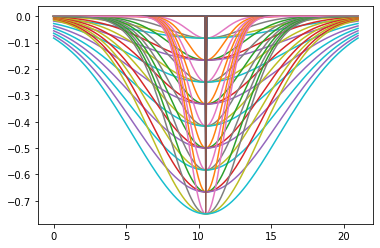

niters = 907200.0
forcing_period = 5400.0 seconds


In [31]:
hours = 60 * 60
days = 24 * hours

deltat = 2
end_time = 21 * days
niters = end_time / deltat

forcing_period = 1.5 * hours
exf_forcing_iters = forcing_period / deltat

tmid = 10.5 * days

times = xr.DataArray(np.arange(0, end_time + 1e-9, forcing_period), name='time', dims='time')
nt = len(times)

def wind_stress(t, tau_max=tau_max, sigmat=sigmat):
    stress = tau_max * np.exp(-np.square((t - tmid)) / 2 / np.square(sigmat)) * xr.ones_like(ds_input['XC'])
    return stress


for array_elem in range(len(wind_params)):
    # Calculate the wind stress
    merid_wind_stress = wind_stress(times, *wind_params[array_elem])
    plt.plot(times / 24 / 60 / 60, merid_wind_stress.isel(XC=0))
    
    # Now setup the run directory for the ensemble member
    run_path = ensemble_path / 'run{}_a'.format(array_elem)
    input_path = run_path / 'input'
    
    run_path.mkdir(parents=True, exist_ok=True)
    
    input_path.mkdir(exist_ok=True)
    for file in list(input_binary_files.glob('*')):
        input_path / file.name
        if not (input_path / file.name).exists():
            (input_path / file.name).symlink_to(file)
    
    for file in list(input_data_files.glob('*')):
        if not (run_path / file.name).exists():
            (run_path / file.name).symlink_to(file)
    
    print(run_path)
    merid_wind_stress = merid_wind_stress.transpose('time', 'Z', 'Zl', 'Zu', 'Zp1', 'YG', 'YC', 'XG', 'XC', missing_dims='ignore')
    # Now save the wind stress
    fbase = str(input_path / 'merid_wind_stress')
    mds.wrmds(fbase, merid_wind_stress.values[:, None, :], dataprec='float32')
        
plt.show()

print('niters = {}'.format(niters))
print('forcing_period = {} seconds'.format(forcing_period))

In [ ]:
wind_params

[(0.0, 1e-09),
 (0.0, 108000.00000000076),
 (0.0, 216000.0000000005),
 (0.0, 324000.00000000023),
 (0.0, 432000.0),
 (-0.08333333333333333, 1e-09),
 (-0.08333333333333333, 108000.00000000076),
 (-0.08333333333333333, 216000.0000000005),
 (-0.08333333333333333, 324000.00000000023),
 (-0.08333333333333333, 432000.0),
 (-0.16666666666666666, 1e-09),
 (-0.16666666666666666, 108000.00000000076),
 (-0.16666666666666666, 216000.0000000005),
 (-0.16666666666666666, 324000.00000000023),
 (-0.16666666666666666, 432000.0),
 (-0.25, 1e-09),
 (-0.25, 108000.00000000076),
 (-0.25, 216000.0000000005),
 (-0.25, 324000.00000000023),
 (-0.25, 432000.0),
 (-0.3333333333333333, 1e-09),
 (-0.3333333333333333, 108000.00000000076),
 (-0.3333333333333333, 216000.0000000005),
 (-0.3333333333333333, 324000.00000000023),
 (-0.3333333333333333, 432000.0),
 (-0.41666666666666663, 1e-09),
 (-0.41666666666666663, 108000.00000000076),
 (-0.41666666666666663, 216000.0000000005),
 (-0.41666666666666663, 324000.00000000

[(0.0, 1e-09),
 (0.0, 108000.00000000076),
 (0.0, 216000.0000000005),
 (0.0, 324000.00000000023),
 (0.0, 432000.0),
 (-0.08333333333333333, 1e-09),
 (-0.08333333333333333, 108000.00000000076),
 (-0.08333333333333333, 216000.0000000005),
 (-0.08333333333333333, 324000.00000000023),
 (-0.08333333333333333, 432000.0),
 (-0.16666666666666666, 1e-09),
 (-0.16666666666666666, 108000.00000000076),
 (-0.16666666666666666, 216000.0000000005),
 (-0.16666666666666666, 324000.00000000023),
 (-0.16666666666666666, 432000.0),
 (-0.25, 1e-09),
 (-0.25, 108000.00000000076),
 (-0.25, 216000.0000000005),
 (-0.25, 324000.00000000023),
 (-0.25, 432000.0),
 (-0.3333333333333333, 1e-09),
 (-0.3333333333333333, 108000.00000000076),
 (-0.3333333333333333, 216000.0000000005),
 (-0.3333333333333333, 324000.00000000023),
 (-0.3333333333333333, 432000.0),
 (-0.41666666666666663, 1e-09),
 (-0.41666666666666663, 108000.00000000076),
 (-0.41666666666666663, 216000.0000000005),
 (-0.41666666666666663, 324000.00000000

In [38]:
216000 / 24 / 60 / 60

2.5

In [39]:
tau_max_arr

array([ 0.        , -0.08333333, -0.16666667, -0.25      , -0.33333333,
       -0.41666667, -0.5       , -0.58333333, -0.66666667, -0.75      ])

In [41]:
sigmat_arr

array([1.00e-09, 1.08e+05, 2.16e+05, 3.24e+05, 4.32e+05])

In [42]:
list(enumerate(wind_params))

[(0, (0.0, 1e-09)),
 (1, (0.0, 108000.00000000076)),
 (2, (0.0, 216000.0000000005)),
 (3, (0.0, 324000.00000000023)),
 (4, (0.0, 432000.0)),
 (5, (-0.08333333333333333, 1e-09)),
 (6, (-0.08333333333333333, 108000.00000000076)),
 (7, (-0.08333333333333333, 216000.0000000005)),
 (8, (-0.08333333333333333, 324000.00000000023)),
 (9, (-0.08333333333333333, 432000.0)),
 (10, (-0.16666666666666666, 1e-09)),
 (11, (-0.16666666666666666, 108000.00000000076)),
 (12, (-0.16666666666666666, 216000.0000000005)),
 (13, (-0.16666666666666666, 324000.00000000023)),
 (14, (-0.16666666666666666, 432000.0)),
 (15, (-0.25, 1e-09)),
 (16, (-0.25, 108000.00000000076)),
 (17, (-0.25, 216000.0000000005)),
 (18, (-0.25, 324000.00000000023)),
 (19, (-0.25, 432000.0)),
 (20, (-0.3333333333333333, 1e-09)),
 (21, (-0.3333333333333333, 108000.00000000076)),
 (22, (-0.3333333333333333, 216000.0000000005)),
 (23, (-0.3333333333333333, 324000.00000000023)),
 (24, (-0.3333333333333333, 432000.0)),
 (25, (-0.4166666666